https://raw.githubusercontent.com/limsk405/keras/master/keras_util_show_AE.py

In [2]:
# utility to display various images from autoencoder: 
# (1) input, (2) encoded input, (3) decoded input
# written by Sung Kyu Lim
# limsk@ece.gatech.edu
# 1/5/2019


# imports
import matplotlib.pyplot as plt


# x_test is the original image
# encoded is the encoder output 
# (if dim = 1, show histogram. otherwise, show 2D image)
# decoded is the decoder output image
def show_AE(x_test, encoded, decoded, dim):
    Nout = 10

    print('\nOriginal test image shape:', x_test.shape)
    print('Encoded test image shape:', encoded.shape)
    print('Decoded test image shape:', decoded.shape)

    plt.figure(figsize = (20, 6))
    for i in range(Nout):
        # show the input image
        ax = plt.subplot(3, Nout, i + 1)
        plt.imshow(x_test[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # show the encoded image using histogram
        ax = plt.subplot(3, Nout, i + 1 + Nout)
        if dim == 1:
            plt.stem(encoded[i].reshape(-1))
        else:
            plt.imshow(encoded[i].reshape(7, 7))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # show the decoded image
        ax = plt.subplot(3, Nout, i + 1 + Nout + Nout)
        plt.imshow(decoded[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

- label정보 없이 알아서 classification하는 코드
- 일일이 label붙일 필요 없는..?
- 시계열 데이터에 오토인코더 적용 가능?

- 주가 데이터를 인풋으로 받은 후 주가가 오를 것이나 내릴 것이다를 분류하는 도메인에 오토인코더 적용 가능? 즉, feature extraction이 가능하다?
- 사람의 라벨링과 차이가 있지 않을까? 무엇이 더 낫나? 정확도가 없음.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 4)         40        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 4)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 8)         296       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 1)           393       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 16)          160       
__________

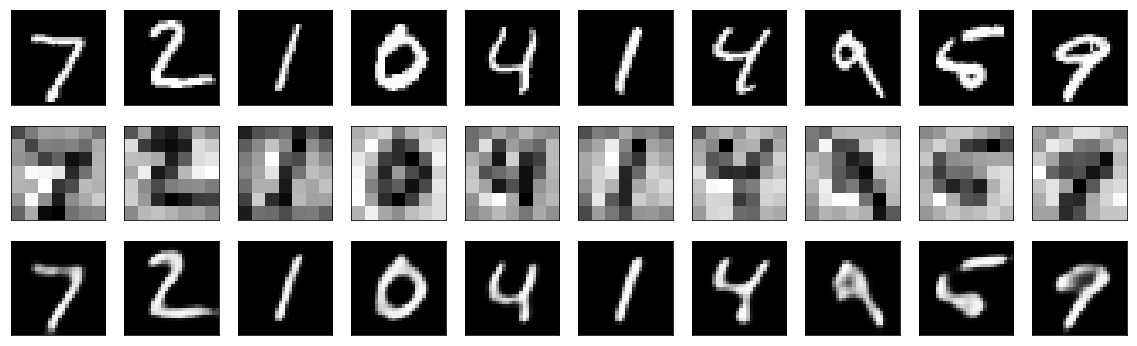

In [4]:
# MNIST image reconstruction with keras CNN autoencoder
# written by Sung Kyu Lim
# limsk@ece.gatech.edu
# 1/5/2019


# imports
import numpy as np
from keras import models, layers
from keras import datasets
# from keras_util_show_AE import show_AE


# remove annoying warning
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'


# simplified convolution function for readability
# Generate Auto-Encoder using CNN in this case.
def Conv2D(channel, size_filters, padding = 'SAME', activation = 'relu'):
    '''
    channel: number of image
    
    '''
    return layers.Conv2D(channel, size_filters, padding = padding, activation = activation)


# CNN autoencoder model construction
def AE_CNN():
    # input layer
    shape_in = (28, 28, 1) 
    image = layers.Input(shape = shape_in)

    # 5-layer encoder
    # max-pooling reduces image size: 28 -> 14 -> 7
    x = Conv2D(4, (3, 3))(image)
    x = layers.MaxPooling2D((2, 2), padding = 'SAME')(x)
    x = Conv2D(8, (3, 3))(x)
    x = layers.MaxPooling2D((2, 2), padding = 'SAME')(x)
    h = Conv2D(1, (7, 7))(x)
    encoder = models.Model(image, h)  

    # 5-layer decoder
    # upscaling increases image size: 7 -> 14 -> 28
    y = Conv2D(16, (3, 3))(h)
    y = layers.UpSampling2D((2, 2))(y)
    y = Conv2D(8, (3, 3))(y)
    y = layers.UpSampling2D((2, 2))(y)
    y = Conv2D(4, (3, 3))(y)
    z = Conv2D(1, (3, 3), activation = 'sigmoid')(y)

    # full range autoencoder
    model = models.Model(image, z)
    model.compile(optimizer = 'adadelta', loss = 'binary_crossentropy')
    model.summary()

    return model, encoder


# read and reshape MNIST data for CNN autoencoder
def data_func():
    # True: show database details, False: do not show
    DEBUG = True

    # note that we do not need output labels!
    # this means we are doing unsupervised learning
    (x_train, _), (x_test, _) = datasets.mnist.load_data()

    # reshaping 2D image (28 x 28) to 3D image with channel info (28 x 28 x 1)
    if DEBUG:
        print('Input shape before reshaping:', x_train.shape)
    
    rows, cols = x_train.shape[1:]
    x_train = x_train.reshape(x_train.shape[0], rows, cols, 1)
    x_test = x_test.reshape(x_test.shape[0], rows, cols, 1)
    
    if DEBUG:
        print('Input shape after reshaping:', x_train.shape)

    # make pixel data float (to compute with float weights)
    x_train = x_train.astype('float32') / 255
    x_test = x_test.astype('float32') / 255

    return (x_train, x_test)


# main function
def main():
    # create a CNN autoencoder and the MNIST database
    autoencoder, encoder = AE_CNN()
    (x_train, x_test) = data_func()

    # conduct learning
    # note we do not use "y_train", the output label 
    # because autoencoder is unsupervised
    autoencoder.fit(x_train, x_train, epochs = 3, batch_size = 128, validation_split = 0.2)

    # show related images
    # last entry is the dimension of the encoded image
    # we need to run the autoencoder model using "predict" 
    # to produce the encoded/decoded images
    encoded = encoder.predict(x_test)
    decoded = autoencoder.predict(x_test)
    show_AE(x_test, encoded, decoded, 2)


# this is how we call main function
if __name__ == '__main__':
    main()

- 해상도가 낮은 이미지만 넘겨도 좋은 화질로 볼 수 있는 기술에도 쓰일 수 있나?
- 예를 들면 차량번호판. 범인 얼굴 인식

In [ ]:
8